## Causal Inference

### Simpson Paradox

In [1]:
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import CausalInference

<Axes: >

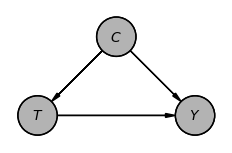

In [2]:
simp_model = BayesianNetwork([("C", "T"), ("T", "Y"), ("C", "Y")])
simp_model.to_daft(node_pos={"T": (0, 0), "Y": (2, 0), "C": (1, 1)}).render()

In [3]:
cpd_s = TabularCPD(
    variable="C", variable_card=2, values=[[0.5], [0.5]], state_names={"C": ["m", "f"]}
)
cpd_t = TabularCPD(
    variable="T",
    variable_card=2,
    values=[[0.25, 0.75], [0.75, 0.25]],
    evidence=["C"],
    evidence_card=[2],
    state_names={"C": ["m", "f"], "T": [0, 1]},
)
cpd_c = TabularCPD(
    variable="Y",
    variable_card=2,
    values=[[0.3, 0.4, 0.7, 0.8], [0.7, 0.6, 0.3, 0.2]],
    evidence=["C", "T"],
    evidence_card=[2, 2],
    state_names={"C": ["m", "f"], "T": [0, 1], "Y": [0, 1]},
)

simp_model.add_cpds(cpd_s, cpd_t, cpd_c)

#### Inference conditioning on T

In [4]:
# Non adjusted inference
infer_non_adjust = VariableElimination(simp_model)
print(infer_non_adjust.query(variables=["Y"], evidence={"T": 1}))
print(infer_non_adjust.query(variables=["Y"], evidence={"T": 0}))

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.5000 |
+------+----------+
| Y(1) |   0.5000 |
+------+----------+
+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.6000 |
+------+----------+
| Y(1) |   0.4000 |
+------+----------+


#### Inference with do on T

In [5]:
infer_adjusted = CausalInference(simp_model)
print(infer_adjusted.query(variables=["Y"], do={"T": 1}))
print(infer_adjusted.query(variables=["Y"], do={"T": 0}))

  0%|          | 0/2 [00:00<?, ?it/s]

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.6000 |
+------+----------+
| Y(1) |   0.4000 |
+------+----------+


  0%|          | 0/2 [00:00<?, ?it/s]

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.5000 |
+------+----------+
| Y(1) |   0.5000 |
+------+----------+


#### Specifying adjustment set

In [6]:
infer_simp = CausalInference(simp_model)
do_simpson = infer_simp.query(["Y"], do={"T": 1}, adjustment_set=["C"])
print(do_simpson)

adj_simpson = infer_simp.query(["Y"], adjustment_set=["C"])
print(adj_simpson)

  0%|          | 0/2 [00:00<?, ?it/s]

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.6000 |
+------+----------+
| Y(1) |   0.4000 |
+------+----------+
+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.5500 |
+------+----------+
| Y(1) |   0.4500 |
+------+----------+


## A more complex model

<Axes: >

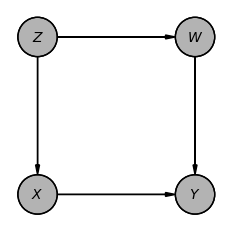

In [7]:
model = BayesianNetwork([("X", "Y"), ("Z", "X"), ("Z", "W"), ("W", "Y")])
cpd_z = TabularCPD(variable="Z", variable_card=2, values=[[0.2], [0.8]])

cpd_x = TabularCPD(
    variable="X",
    variable_card=2,
    values=[[0.1, 0.3], [0.9, 0.7]],
    evidence=["Z"],
    evidence_card=[2],
)

cpd_w = TabularCPD(
    variable="W",
    variable_card=2,
    values=[[0.2, 0.9], [0.8, 0.1]],
    evidence=["Z"],
    evidence_card=[2],
)

cpd_y = TabularCPD(
    variable="Y",
    variable_card=2,
    values=[[0.3, 0.4, 0.7, 0.8], [0.7, 0.6, 0.3, 0.2]],
    evidence=["X", "W"],
    evidence_card=[2, 2],
)

model.add_cpds(cpd_z, cpd_x, cpd_w, cpd_y)

model.to_daft(node_pos={"X": (0, 0), "Y": (2, 0), "Z": (0, 2), "W": (2, 2)}).render()

In [9]:
# Not adjusted inference
infer_non_adjust = VariableElimination(model)
print(infer_non_adjust.query(variables=["Y"], evidence={"X": 1}))

# Do operation with a specified adjustment set.
infer = CausalInference(model)
do_X_W = infer.query(["Y"], do={"X": 1}, adjustment_set=["W"])
print(do_X_W)

do_X_Z = infer.query(["Y"], do={"X": 1}, adjustment_set=["Z"])
print(do_X_Z)

do_X_WZ = infer.query(["Y"], do={"X": 1}, adjustment_set=["W", "Z"])
print(do_X_WZ)

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.7270 |
+------+----------+
| Y(1) |   0.2730 |
+------+----------+


  0%|          | 0/2 [00:00<?, ?it/s]

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.7240 |
+------+----------+
| Y(1) |   0.2760 |
+------+----------+


  0%|          | 0/2 [00:00<?, ?it/s]

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.7240 |
+------+----------+
| Y(1) |   0.2760 |
+------+----------+


  0%|          | 0/4 [00:00<?, ?it/s]

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.7240 |
+------+----------+
| Y(1) |   0.2760 |
+------+----------+


In [15]:
# Not adjusted inference
infer_non_adjust = VariableElimination(model)
print(infer_non_adjust.query(variables=["Y"], evidence={"X": 1}))
print(infer_non_adjust.query(variables=["Y"], evidence={"X": 0}))

# Do operation with a specified adjustment set.
infer = CausalInference(model)
do_X_W = infer.query(["Y"], do={"X": 1}, adjustment_set=["W"])
print(do_X_W)
do_X_W = infer.query(["Y"], do={"X": 0}, adjustment_set=["W"])
print(do_X_W)

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.7270 |
+------+----------+
| Y(1) |   0.2730 |
+------+----------+
+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.3154 |
+------+----------+
| Y(1) |   0.6846 |
+------+----------+


  0%|          | 0/2 [00:00<?, ?it/s]

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.7240 |
+------+----------+
| Y(1) |   0.2760 |
+------+----------+


  0%|          | 0/2 [00:00<?, ?it/s]

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.3240 |
+------+----------+
| Y(1) |   0.6760 |
+------+----------+


In [12]:
# Adjustment without do operation.
infer = CausalInference(model)
adj_W = infer.query(["Y"], adjustment_set=["W"])
print(adj_W)
print()

adj_Z = infer.query(["Y"], adjustment_set=["Z"])
print(adj_Z)
print()

adj_WZ = infer.query(["Y"], adjustment_set=["W", "Z"])
print(adj_WZ)

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.6200 |
+------+----------+
| Y(1) |   0.3800 |
+------+----------+

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.6200 |
+------+----------+
| Y(1) |   0.3800 |
+------+----------+

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.6200 |
+------+----------+
| Y(1) |   0.3800 |
+------+----------+
